In [1]:
from google.colab import files
uploaded = files.upload()

Saving ptbxl_database.csv to ptbxl_database.csv
Saving scp_statements.csv to scp_statements.csv


In [2]:
from google.colab import files
uploaded = files.upload()

Saving 01000_lr.dat to 01000_lr.dat
Saving 01000_lr.hea to 01000_lr.hea
Saving 01001_lr.dat to 01001_lr.dat



📋 TEXT REPRESENTATION OF TREE:

Feature: Size
 ├── [0]
  Leaf -> Yes
 ├── [1]
  Leaf -> No
 ├── [2]
  Leaf -> Yes


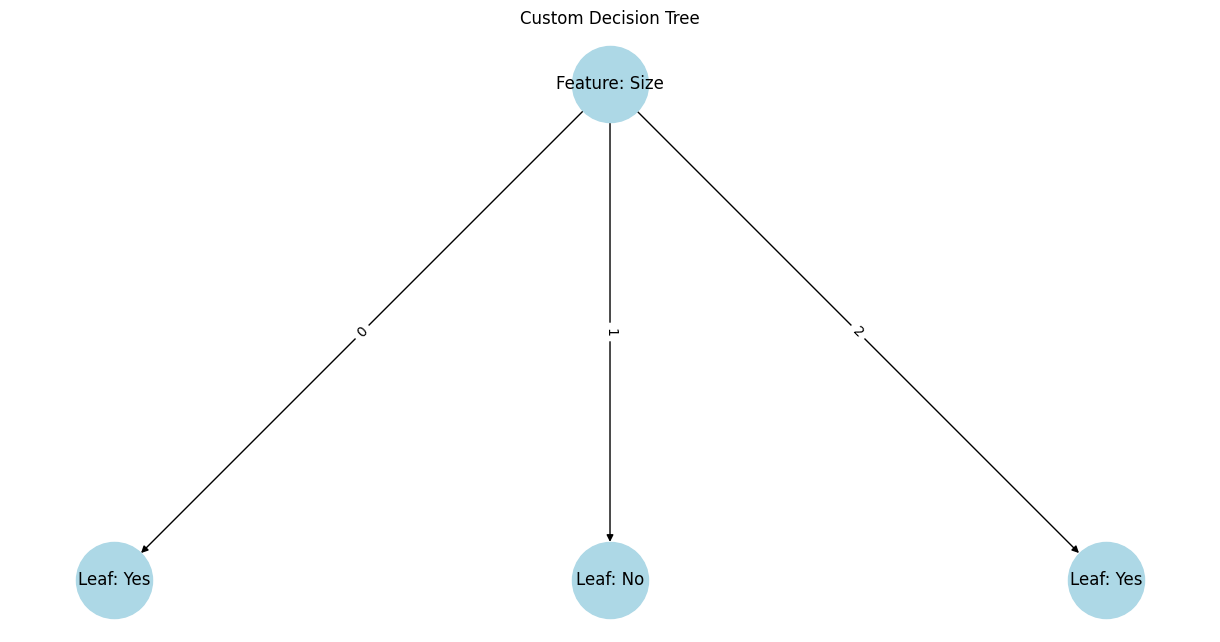

In [7]:
# a6
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# ---------------------------------------------------
# 1. BINNING FUNCTION
# ---------------------------------------------------
def bin_feature(series, n_bins=4, method="equal_width"):
    """
    Convert a continuous feature into categorical bins.
    Parameters:
        series (pd.Series): Input feature.
        n_bins (int): Number of bins.
        method (str): 'equal_width' or 'equal_frequency'
    Returns:
        pd.Series: Binned categorical feature.
    """
    if method == "equal_width":
        return pd.cut(series, bins=n_bins, labels=False, include_lowest=True)
    elif method == "equal_frequency":
        return pd.qcut(series, q=n_bins, labels=False, duplicates='drop')
    else:
        raise ValueError("Invalid method: choose 'equal_width' or 'equal_frequency'")

# ---------------------------------------------------
# 2. ENTROPY + INFO GAIN
# ---------------------------------------------------
def calculate_entropy(y):
    counts = Counter(y)
    total = len(y)
    return -sum((count / total) * np.log2(count / total) for count in counts.values())

def information_gain(df, feature, target):
    total_entropy = calculate_entropy(target)
    weighted_entropy = 0
    for value in df[feature].unique():
        subset_target = target[df[feature] == value]
        weighted_entropy += (len(subset_target) / len(target)) * calculate_entropy(subset_target)
    return total_entropy - weighted_entropy

# ---------------------------------------------------
# 3. TREE NODE CLASS
# ---------------------------------------------------
class TreeNode:
    def __init__(self, feature=None, label=None):
        self.feature = feature
        self.label = label
        self.children = {}

# ---------------------------------------------------
# 4. BUILD DECISION TREE
# ---------------------------------------------------
def build_decision_tree(df, target, depth=0, max_depth=3):
    if len(set(target)) == 1:
        return TreeNode(label=target.iloc[0])

    if depth >= max_depth or df.shape[1] == 0:
        majority = Counter(target).most_common(1)[0][0]
        return TreeNode(label=majority)

    gains = {col: information_gain(df, col, target) for col in df.columns}
    best_feature = max(gains, key=gains.get)

    node = TreeNode(feature=best_feature)

    for value in df[best_feature].unique():
        subset_df = df[df[best_feature] == value].drop(columns=[best_feature])
        subset_target = target[df[best_feature] == value]

        if subset_df.empty:
            majority = Counter(target).most_common(1)[0][0]
            node.children[value] = TreeNode(label=majority)
        else:
            node.children[value] = build_decision_tree(subset_df, subset_target, depth + 1, max_depth)

    return node

# ---------------------------------------------------
# 5. PREDICTION
# ---------------------------------------------------
def predict_single(tree, row):
    if tree.label is not None:
        return tree.label
    value = row.get(tree.feature)
    if value in tree.children:
        return predict_single(tree.children[value], row)
    # fallback to majority class among children
    labels = [child.label for child in tree.children.values() if child.label is not None]
    return Counter(labels).most_common(1)[0][0]

def predict(tree, df):
    return [predict_single(tree, row) for _, row in df.iterrows()]

# ---------------------------------------------------
# 6. TEXT-BASED TREE PRINTER
# ---------------------------------------------------
def print_tree(node, depth=0):
    indent = "  " * depth
    if node.label is not None:
        print(f"{indent}Leaf -> {node.label}")
    else:
        print(f"{indent}Feature: {node.feature}")
        for value, child in node.children.items():
            print(f"{indent} ├── [{value}]")
            print_tree(child, depth + 1)

# ---------------------------------------------------
# 7. TREE VISUALIZER
# ---------------------------------------------------
def draw_decision_tree(root):
    if root is None:
        print("⚠️ Tree is empty!")
        return

    G = nx.DiGraph()

    def add_nodes_edges(node, parent=None, edge_label=None, counter=[0]):
        current_id = counter[0]
        counter[0] += 1

        label = f"Leaf: {node.label}" if node.label is not None else f"Feature: {node.feature}"
        G.add_node(current_id, label=label)

        if parent is not None:
            G.add_edge(parent, current_id, label=str(edge_label))

        for val, child in node.children.items():
            add_nodes_edges(child, current_id, edge_label=val, counter=counter)

    add_nodes_edges(root)

    try:
        pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
    except:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color="lightblue")
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'))
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))
    plt.title("Custom Decision Tree")
    plt.axis("off")
    plt.show()

# ---------------------------------------------------
# 8. DECISION BOUNDARY VISUALIZATION (FOR 2 FEATURES)
# ---------------------------------------------------
def plot_decision_boundary(tree, df, target, feature_names, h=0.1):
    if len(feature_names) != 2:
        raise ValueError("Exactly two features required for decision boundary visualization.")

    X = df[feature_names].values
    y = np.array(target)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=feature_names)

    # Binning grid to match training
    for f in feature_names:
        if pd.api.types.is_numeric_dtype(df[f]):
            grid_df[f] = bin_feature(grid_df[f], n_bins=len(df[f].unique()))

    Z = np.array(predict(tree, grid_df)).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    for label in np.unique(y):
        idx = y == label
        plt.scatter(X[idx, 0], X[idx, 1], label=f"Class {label}", edgecolor="k")
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Decision Boundary")
    plt.legend()
    plt.show()

# ---------------------------------------------------
# 9. DEMO USAGE
# ---------------------------------------------------
if __name__ == "__main__":
    data = {
        "Color": ["Red", "Red", "Blue", "Blue", "Green", "Red"],
        "Size": [10, 20, 15, 30, 25, 35],
        "Shape": ["Round", "Square", "Round", "Square", "Round", "Round"]
    }
    target = pd.Series(["Yes", "No", "Yes", "Yes", "No", "Yes"])
    df = pd.DataFrame(data)

    # Binning continuous feature
    df["Size"] = bin_feature(df["Size"], n_bins=3)

    tree = build_decision_tree(df, target, max_depth=3)
    print("\n📋 TEXT REPRESENTATION OF TREE:\n")
    print_tree(tree)
    draw_decision_tree(tree)

    # Uncomment if you want decision boundary (only if you have exactly 2 features):
    # plot_decision_boundary(tree, df, target, ["Size", "Color"])
